Loading the dataset

In [29]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import random
from matplotlib import pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [30]:
from google.colab import drive

#drive already mounted
drive.mount('/content/drive') 

DATA_PATH = "/content/drive/MyDrive/cs231n/assignments/assignment1/train_data.pkl"


with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']

# normalise
#X_norm = X - np.min(X, axis = 0, keepdims = True)
#X_norm = X_norm / (np.max(X_norm, axis = 0, keepdims = True) + 1e-6)

#new version
X_norm = preprocessing.normalize(X)

#split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify = y, test_size = 0.9) 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


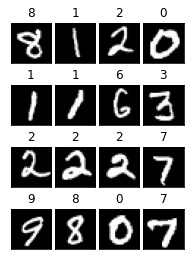

In [31]:
#displaying grid
for i in range(16):
  idx = random.randrange(0,60000,1)
  plt.subplot(4,4,i+1)
  image = np.reshape(X[idx], (28,28))
  drawing = plt.imshow(image, cmap = "gray")
  plt.title(y[idx][0])
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.5, top = 0.9, wspace = 0.1, hspace = 0.4)
plt.show()

Activation functions

In [32]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    # here additional constant is mutiplied in both numerator and denominator of
    # softmax to prevent exponents going too high
    # Here constant is max yj

    #here data can never turn y to have zero, so dividing by it causes no issue

    temp = np.max(z, axis = 1, keepdims = True)
    z = z - temp

    z = np.exp(z)
    y = z.sum(axis = 1, keepdims = True)
    
    return z / y

Initializing the layer weights

In [33]:
def init_params(layers_dims): #array containing size of each layer
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        # He Initialization is used for W's while all bias vectors are set to 0 initially

        #no problem in dividing as it is never zero
        parameters['W' + str(l)] = np.random.randn(layers_dims[l - 1], layers_dims[l]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

Forward Propagation

In [34]:
def forward_propg(X, parameters):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    

    # LINEAR -> RELU -> LINEAR 
    z1 = np.dot(X, W1) + b1.T
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2.T
    a2 = softmax(z2)

    cache = (z1, a1, W1, b1, z2, a2, W2, b2)
    
    return a2, cache
    

Backward Propagation

In [35]:
def backward_propg(weights, X, y, cache, lr):
    """
    should update the weights and return updated weights
    """
    #learning rate is stored here
    learning_rate = lr
    m = X.shape[0]
    (z1, a1, W1, b1, z2, a2, W2, b2) = cache

    da2 = np.zeros(a2.shape)
    for i in range(m):
      if a2[i][y[i][0]] != 0:
        da2[i][y[i][0]] = -1./(a2[i][y[i][0]] * m)
    
    #My method original
    #dz2 = (a2)*(1-a2)*da2

    #Soham's Method
    #mask = np.zeros((y.size, 10)) # creates one-hot encoded mask (2D)
    #mask[np.arange(y.size),y] = 1
    #mask = mask.T  # mask created
    #dz2 = a2 - mask  

    #My method 2
    temp = -a2
    for i in range(m):
      temp[i][y[i][0]] = temp[i][y[i][0]] + 1
    temp2 = np.zeros((m, 1))

    for i in range (m) :
      temp2[i][0] = a2[i][y[i][0]]
    dz2t = temp * temp2
    dmult = np.zeros((m,1))

    for i in range(m) :
      dmult[i][0] = da2[i][y[i][0]] 
    dz2 = dz2t * dmult

    #it did gradient killing, faulty logic here 
    #dz2 = np.multiply(a2, (np.ones(a2.shape) - np.sum(a2, axis = 1, keepdims = True)))

    dW2 = np.dot(a1.T, dz2)
    db2T = np.sum(dz2, axis=0, keepdims = True)
    db2 = db2T.T
    da1 = np.dot(dz2, W2.T)

    dz1 = np.multiply(da1, np.int64(a1 > 0)) #grad for ReLU pass
    dW1 = np.dot(X.T, dz1)
    db1T = np.sum(dz1, axis=0, keepdims = True)
    db1 = db1T.T
    
    grads = {"da2":da2, "dz2": dz2, "dW2": dW2, "db2": db2, "da1": da1,
                 "dz1": dz1, "dW1": dW1, "db1": db1}
    
    L = len(weights) // 2 # number of layers in the neural networks

    # Update rule for each parameter, Vanilla Method
    for k in range(L):
        weights["W" + str(k+1)] = weights["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        weights["b" + str(k+1)] = weights["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return weights

In [36]:
def cost_func(y, a2):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    #for loss will use softmax defined earlier
    #Here also m can never be zero hence division won't cause zero error
    intmed = - np.log(a2)
    loss = 0
    m = y.shape[0]
    for i in range (m):
      loss = loss + intmed[i][y[i][0]]
    return loss / m

Integrating everything

In [37]:
def train(X, y, hidden_nodes, epochs=1000, lr=1):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    layers_dims = (784, 128, 10)

    # initialize weights.
    parameters = init_params(layers_dims)

    for i in range(epochs):
        # forward propagation
        a2, cache = forward_propg(X, parameters)

        # print cost at every 100 or so iterations
        cost = cost_func(y, a2)
        if i % 50 == 0 :
          print("The cost after {} iteration is :".format(i), cost)
        
        # backward propagation
        parameters = backward_propg(parameters, X, y, cache,lr)
    return parameters  


In [38]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    num_test = X.shape[0]
    a2, cache = forward_propg(X, updated_weights)
    max = a2.argmax(axis=1)
    Ypred = np.zeros((num_test,1))
    for i in range(num_test):
      Ypred[i][0] = max[i]
    return Ypred
    

In [39]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    print("accuracy :", np.mean(y == predictions))

The cost after 0 iteration is : 2.303475118856281
The cost after 50 iteration is : 0.9616421899610855
The cost after 100 iteration is : 0.5490377663625178
The cost after 150 iteration is : 0.4331302985596207
The cost after 200 iteration is : 0.3789282991124654
The cost after 250 iteration is : 0.3461450537278004
The cost after 300 iteration is : 0.323056245909422
The cost after 350 iteration is : 0.3051566657122567
The cost after 400 iteration is : 0.2904669380037447
The cost after 450 iteration is : 0.2780021619545264
The cost after 500 iteration is : 0.2670654524480094
The cost after 550 iteration is : 0.25715357665055
The cost after 600 iteration is : 0.24809149550228124
The cost after 650 iteration is : 0.23975540149447933
The cost after 700 iteration is : 0.231964235534091
The cost after 750 iteration is : 0.22459337958527495
The cost after 800 iteration is : 0.21764601263964542
The cost after 850 iteration is : 0.21103159256758103
The cost after 900 iteration is : 0.2047321656831

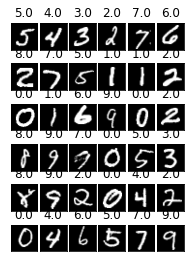

accuracy : 0.9153703703703704


In [40]:
parameters = train(X_train, y_train, 128)
Ypred = predict(X_train, parameters)
print("Train cases")
accuracy(Ypred, y_train)
print()
Ypred = predict(X_test, parameters)
print("Test cases")
accuracy(Ypred, y_test)

#This piece was wriiten to just get the feel of how and what my neural network is 
#predicting.
for i in range(36):
  idx = random.randrange(0,y_test.size,1)
  plt.subplot(6,6,i+1)
  image = np.reshape(X_test[idx], (28,28))
  drawing = plt.imshow(image, cmap = "gray")
  plt.title(Ypred[idx][0])
  drawing.axes.get_xaxis().set_visible(False)
  drawing.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.5, top = 0.9, wspace = 0.1, hspace = 0.4)
plt.show()

accuracy(Ypred, y_test)

Saving the file

In [41]:
import pickle
import random
from google.colab import files

roll_num = "210050082" # enter ldap
hidden_dim = 128 # replace with your own hidden dimension

layer_dims = (784, 128, 10)
parameters = init_params(layer_dims)
model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': parameters["W1"], # layer 0 weight (784, z)
    'layer_0_bias':parameters["b1"] , # layer 0 bias (z, 1)
    'layer_1_wt': parameters["W2"], # layer 1 weight (z, 10)
    'layer_1_bias': parameters["b2"] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>